## Локальный и глобальный поиск

Решите задачу коммивояжера на основе файла данных `hw9_data/tsp.csv`: найти минимальный НЕЦИКЛИЧЕСКИЙ путь (начинается и заканчивается в разных точках), соединяющий N точек. Файл содержит координаты каждого из городов на плоскости (1й столбец - номер города, 2й и 3й - координаты). Используйте L1 расстояние для расчетов и визуализации.



In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from numba import njit
from copy import deepcopy
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

SEED = 19

In [2]:
data = pd.read_csv("./hw9_data/tsp.csv", header=None).drop(columns=[0])
data.columns = ["x", "y"]
print(f"Number of cities: {len(data)}")
data.head()

Number of cities: 52


,x,y
0,565,575
1,25,185
2,345,750
3,945,685
4,845,655


In [3]:
@njit
def dist_l1(a, b):
    return np.sum(np.abs(a - b))

@njit
def get_path_len(data, path):
    length = 0
    for i in range(len(path)-1):
        city0 = data[path[i], :]
        city1 = data[path[i+1], :]
        length += dist_l1(city0, city1)
    return length

In [4]:
base_path = np.array(data.index)
get_path_len(data.values, base_path)

27815

In [5]:
def plot_path(path, label, figsize=(20, 13)):
    crd = data.loc[path].values[:, :]
    plt.figure(figsize=figsize)
    plt.title(f"Path provided by {label} of length {get_path_len(data.values, path)}", fontsize=20)
    plt.scatter(crd[:, 0], crd[:, 1])
    for i in range(crd.shape[0] - 1):
        xa, ya = crd[i]
        xb, yb = crd[i+1]
        plt.plot([xa, xa], [ya, yb], c='b')
        plt.plot([xa, xb], [yb, yb], c='b')
    plt.scatter(crd[[0, -1], 0], crd[[0, -1], 1], c='r', linewidths=20);

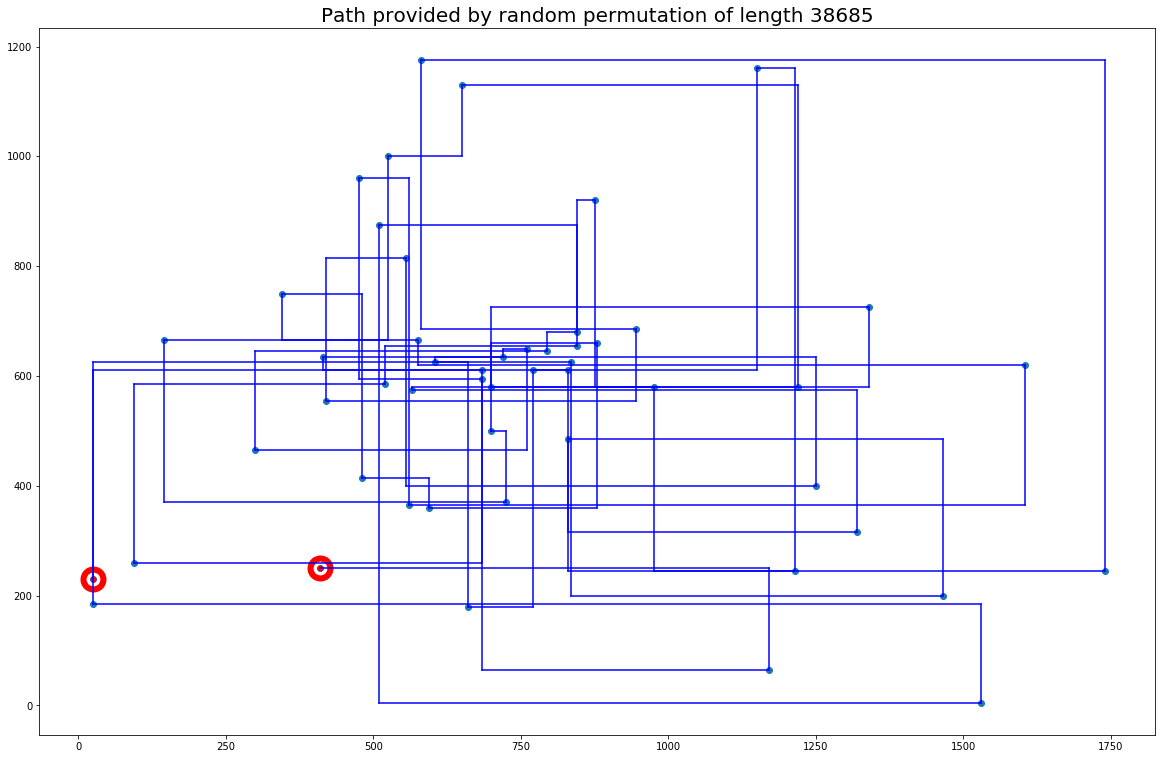

In [6]:
np.random.seed(SEED)
path = np.random.choice(base_path, replace=False, size=len(base_path))
label = "random permutation"
plot_path(path, label)

### Задание 1 (1 балл) 

Реализуйте Монте-Карло поиск.

In [7]:
def mc_search(data, n_iter, rs=SEED):
    np.random.seed(rs)
    base_path = list(data.index)
    best = np.inf, None
    for _ in tqdm(range(n_iter)):
        random_path = np.random.choice(base_path, replace=False, size=len(base_path))
        length = get_path_len(data.values, random_path)
        if length < best[0]:
            best = length, random_path
    return best

In [8]:
path_len, path = mc_search(data, n_iter=int(1e5))
print(f"Shortest path: {path_len}")

100%|██████████| 100000/100000 [00:07<00:00, 13280.54it/s]

Shortest path: 27970


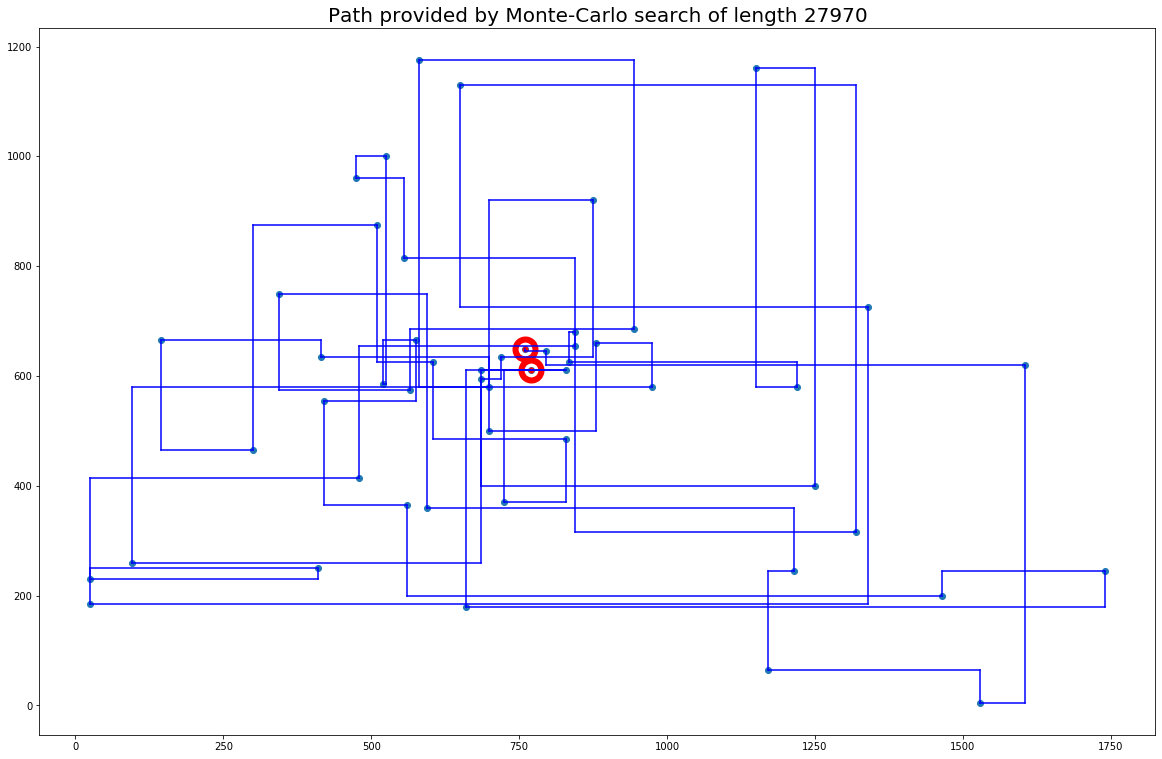

In [9]:
plot_path(path, "Monte-Carlo search")

### Задание 2 (1 балл) 

Реализуйте поиск случайным блужданием.

In [10]:
def rw_search(data, frac, n_trials, n_steps, rs=SEED):
    np.random.seed(SEED)
    base_path = np.array(data.index)
    best = np.inf, None
    for _ in tqdm(range(n_steps)):
        for _ in range(n_trials):
            path = deepcopy(base_path)
            # выбираем случайные точки маршрута и перемешиваем города на них
            picked = np.random.choice(range(len(data)), replace=False, size=round(frac*len(data)))
            shuffled = np.random.choice(path[picked], replace=False, size=len(picked))
            for i, idx in enumerate(picked):
                path[idx] = shuffled[i]
            length = get_path_len(data.values, path)
            if length < best[0]:
                best = length, path
        base_path = best[1]
    return best

In [11]:
path_len, path = rw_search(data, frac=0.1, n_trials=100, n_steps=1000)
print(f"Shortest path: {path_len}")

100%|██████████| 1000/1000 [00:14<00:00, 69.05it/s]

Shortest path: 12430


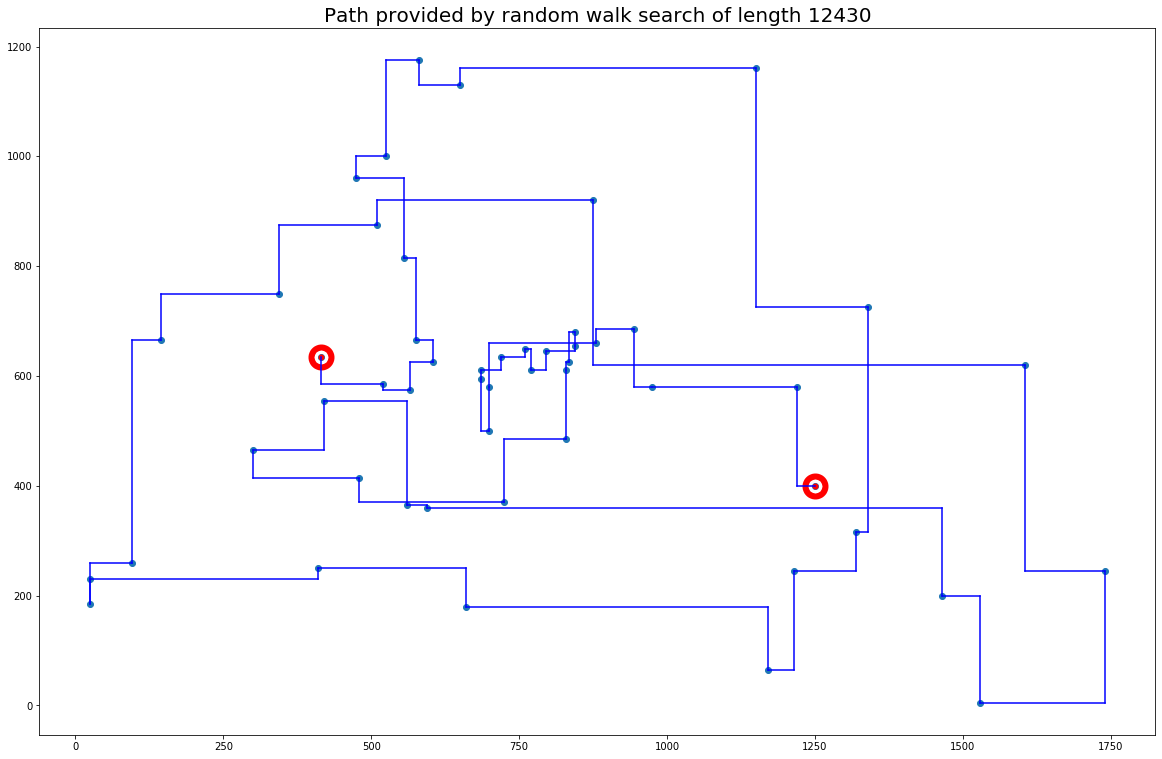

In [12]:
plot_path(path, "random walk search")

### Задание 3 (2 балла) 

Реализуйте Hill Climb.

In [13]:
def hill_climb_search(data, frac, n_iter, stochastic=False, rs=SEED):
    np.random.seed(rs)
    best = np.inf, np.array(data.index)
    for _ in tqdm(range(n_iter)):
        path = deepcopy(best[1])
        # выбираем случайные точки маршрута и перемешиваем города на них
        picked = np.random.choice(range(len(data)), replace=False, size=round(frac*len(data))).astype(int)
        shuffled = np.random.choice(path[picked], replace=False, size=len(picked))
        for i, idx in enumerate(picked):
            path[idx] = shuffled[i]
        length = get_path_len(data.values, path)
        shift = np.random.binomial(1, np.exp(min(0, best[0] - length))) if stochastic \
                else length < best[0]
        best = (length, path) if shift else best
    return best

In [14]:
path_len, path = hill_climb_search(data, frac=0.1, n_iter=100000, stochastic=True)
print(f"Shortest path: {path_len}")

100%|██████████| 100000/100000 [00:15<00:00, 6257.33it/s]

Shortest path: 12305


In [15]:
path_len, path = hill_climb_search(data, frac=0.1, n_iter=100000, stochastic=False)
print(f"Shortest path: {path_len}")

100%|██████████| 100000/100000 [00:14<00:00, 6719.04it/s]

Shortest path: 11790


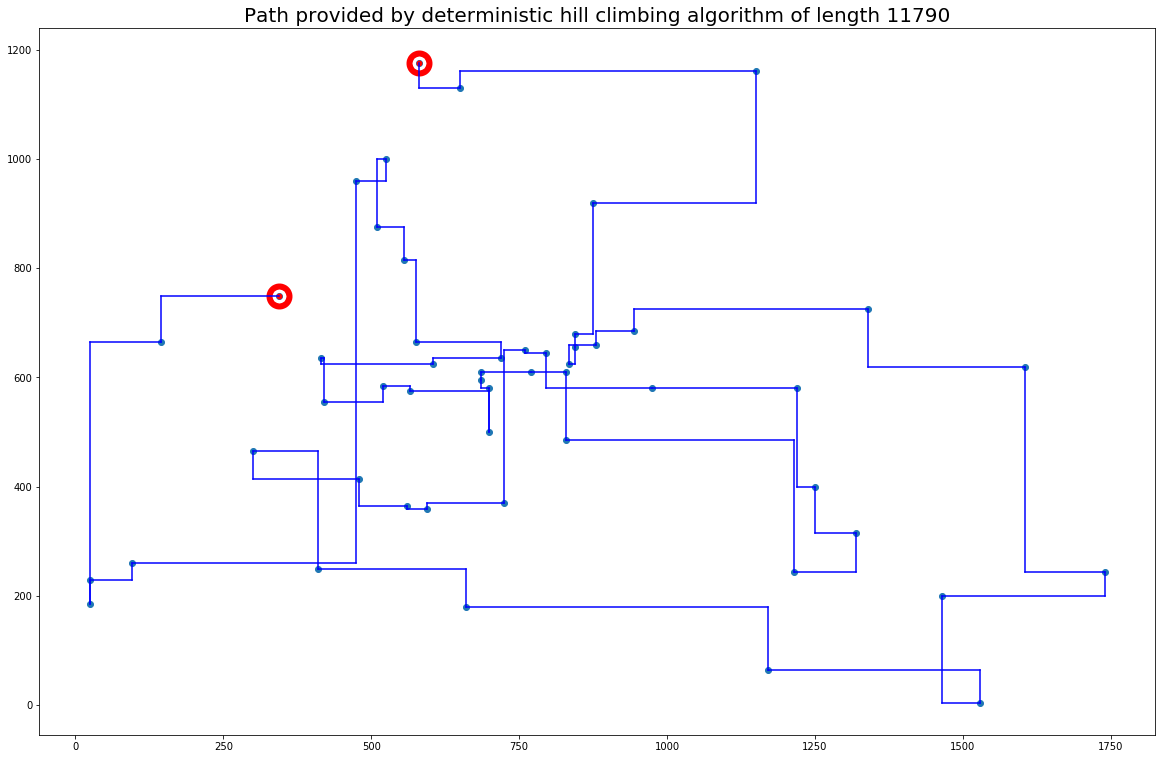

In [16]:
plot_path(path, "deterministic hill climbing algorithm")

### Задание 4 (3 балла) 


Реализуйте отжиг (simulated annealing). Температурный режим отжига выберите самостоятельно.

In [17]:
def anneal_search(data, frac, t0, t1, n_iter, regime="linear", rs=SEED):
    assert regime in ["linear", "exponential"]
    assert t0 > t1
    np.random.seed(rs)
    best = np.inf, np.array(data.index)
    t_list = np.linspace(t0, t1, n_iter) if regime == "linear" else \
             np.logspace(np.log(t0), np.log(t1), n_iter, base=np.e)
    for t in tqdm(t_list):
        path = deepcopy(best[1])
        # выбираем случайные точки маршрута и перемешиваем города на них
        picked = np.random.choice(range(len(data)), replace=False, size=round(frac*len(data))).astype(int)
        shuffled = np.random.choice(path[picked], replace=False, size=len(picked))
        for i, idx in enumerate(picked):
            path[idx] = shuffled[i]
        length = get_path_len(data.values, path)
        shift = np.random.binomial(1, np.exp(min(0, (best[0] - length)/t)))
        best = (length, path) if shift else best
    return best

In [18]:
path_len, path = anneal_search(data, frac=0.1, t0=1000, t1=100, n_iter=100000, regime="linear")
print(f"Shortest path: {path_len}")

100%|██████████| 100000/100000 [00:16<00:00, 6249.42it/s]

Shortest path: 14945


In [19]:
path_len, path = anneal_search(data, frac=0.1, t0=1000, t1=100, n_iter=100000, regime="exponential")
print(f"Shortest path: {path_len}")

100%|██████████| 100000/100000 [00:15<00:00, 6362.02it/s]

Shortest path: 12960


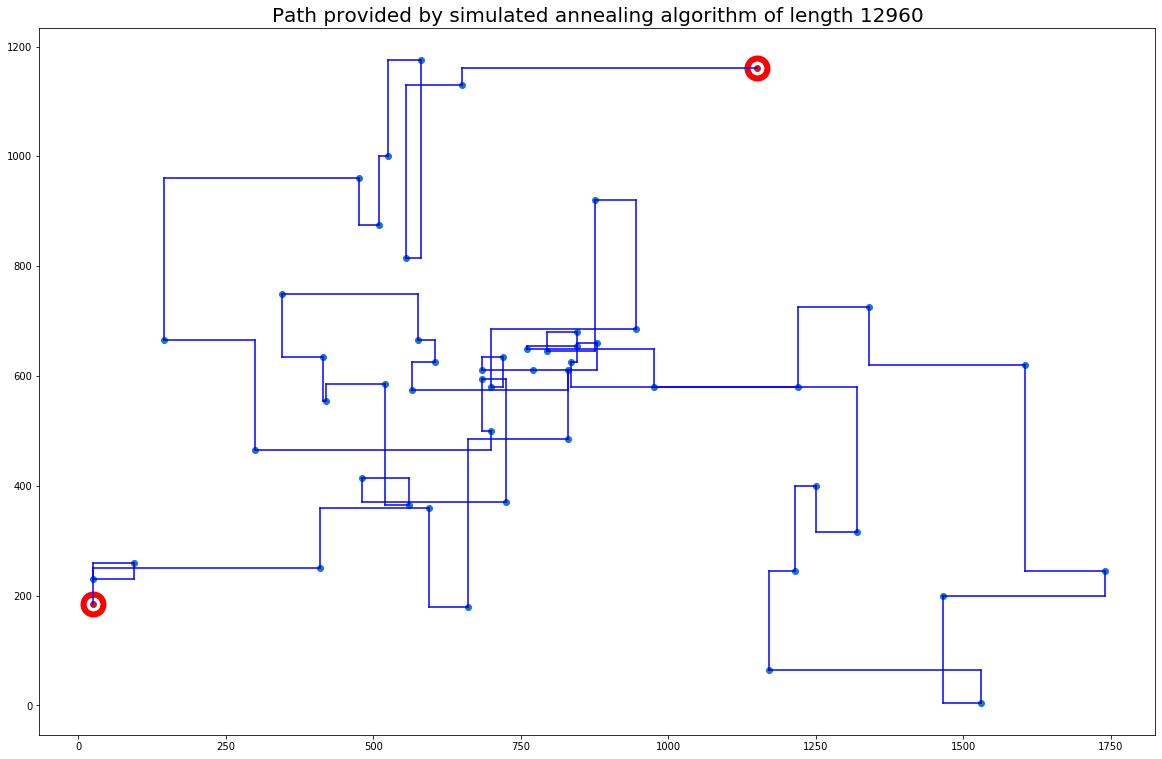

In [20]:
plot_path(path, "simulated annealing algorithm")

### Задание 5 (3 балла) 

Реализуйте генетический алгоритм.

In [21]:
def genetic_search(data, pop_size, n_iter, best_frac, rs=SEED):
    np.random.seed(rs)
    population = [np.random.choice(base_path, replace=False, size=len(base_path)) for _ in range(pop_size)]
    population = [(path, get_path_len(data.values, path)) for path in population]
    population = sorted(population, key=lambda x: x[1], reverse=True)
    for _ in tqdm(range(n_iter)):
        elite_units = np.array([path for path, length in population[:int(best_frac*pop_size)]])
        picked = np.random.choice(range(len(elite_units)), replace=False, size=2)
        male, female = elite_units[picked]
        picked = np.array(np.random.choice(range(len(data)), size=int(len(data)/2), replace=False))
        male = list(male[picked])
        female = [x for x in female if x not in male]
        offspring = []
        while male or female:
            try:
                offspring.append(male.pop(0) if np.random.binomial(1, 0.5) else female.pop(0))
            except IndexError:
                continue
        population[-1] = np.array(offspring)
        population = sorted(population, key=lambda x: x[1], reverse=True)
    return population[0]

In [22]:
path, path_len = genetic_search(data, pop_size=1000, n_iter=10000, best_frac=0.01)
print(f"Shortest path: {path_len}")

100%|██████████| 10000/10000 [00:04<00:00, 2260.16it/s]

Shortest path: 44175


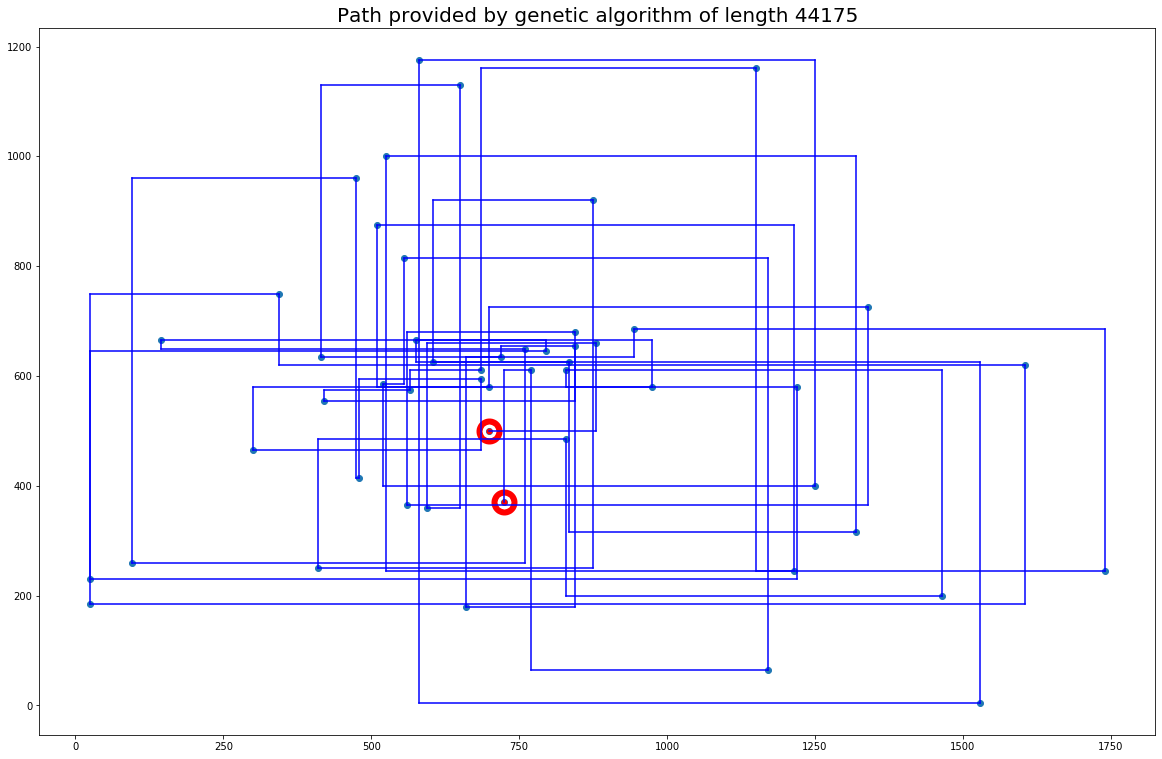

In [23]:
plot_path(path, "genetic algorithm")